### Import Modules

In [1]:
%matplotlib inline

import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import write_geotiff, ga_pq_fuser

sys.path.append('../Scripts')
from dea_bandindices import calculate_indices
from dea_datahandling import load_ard
from dea_plotting import rgb, display_map

dc = datacube.Datacube(app='tcw')

# %load_ext autoreload

# %autoreload 2

### Define a reusable query

In [ ]:
        #Mathoura Large
# 'y': (-35.6545, -36.0320),
# 'x': (144.8179, 145.4289), 
    
    
            #Moria Lakes
# 'y': (-35.9634, -35.8515),
# 'x': (144.8887, 145.0738),
    
                #lake Frome
# 'y': (-30.354, -30.889),
# 'x': (139.482, 140.032),

        #lake carnegie
# 'y': (-36.900, -36.988),
# 'x': (149.800, 149.925),

            #lake carnegie Smol
#'y': (-26.076, -26.352),
#'x': (122.216, 122.552),

# mac marshes
central_lat = -30.714398  #-35.28
central_lon = 147.509603 #149.16

In [174]:
# Set the central latitude and longitude
central_lat = -35.28
central_lon = 149.16

# Set the buffer to load around the central coordinates
buffer = 0.2

# Compute the bounding box for the study area
lats = (central_lat - buffer, central_lat + buffer)
lons = (central_lon - buffer, central_lon + buffer)

display_map(x=lons, y=lats, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [175]:
# Define area of interest
query = { 
    'time': ('2019-01-01', '2019-12-31'),
    'crs': 'EPSG:4326',
    'output_crs': 'EPSG: 3577',
    'resolution': (-30, 30),
    'measurements':['nbart_blue','nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2'],
    'x':lons,
    'y':lats
}

In [176]:
#list(dc.list_products()['name'])

In [177]:
# Load in ARD data
ds_ard = load_ard(dc, products=['ga_ls8c_ard_3'], group_by='solar_day', min_gooddata=0.5, **query)

Loading ga_ls8c_ard_3 data
    Filtering to 8 out of 15 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 8 observations 


In [178]:
# want_to_mask = (ds_ard == -999).to_array(dim='variables').all(dim='variables')
# ds_ard = ds_ard.where(~want_to_mask, np.NaN)

In [179]:
# ds_ard.isel(time=0)

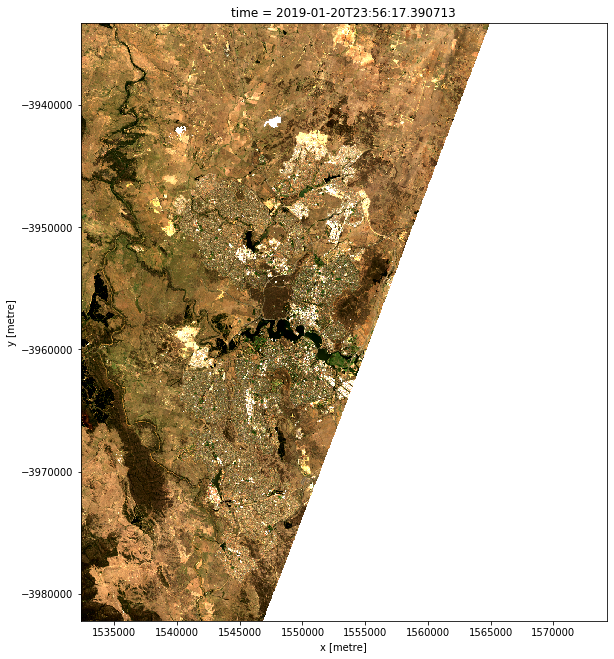

In [180]:
# Plot RGB
rgb(ds_ard.isel(time=1),size=11)

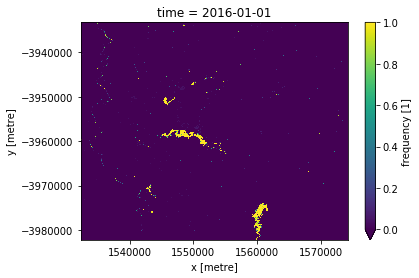

In [181]:
# Define area of interest
query2 = { 
    'time': ('2016-01-01', '2016-12-31'),
    'crs': 'EPSG:4326',
     'output_crs': 'EPSG: 3577',
     'resolution': (-25, 25),
#     'measurements':['nbart_blue','nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2'],
    'x':lons,
    'y':lats
}

# Load in WOfS data
ds_wofs = dc.load(product='wofs_annual_summary', group_by='solar_day', **query2)
ds_wofs.frequency.plot(vmin=0)

In [182]:
ds_wofs.frequency.nodata

-1

### Apply indices
- Tasselled Cap Wetness
- Fisher Index

In [183]:
# Calculate TCW using `calculate indices`
ds_tcw = calculate_indices(ds_ard, index='TCW', collection='ga_ls_3').TCW

# Calculate FI using `calculate indices`
ds_wi = calculate_indices(ds_ard, index='WI', collection='ga_ls_3').WI

#### Plot to check

Text(0.5, 1.0, 'RGB')

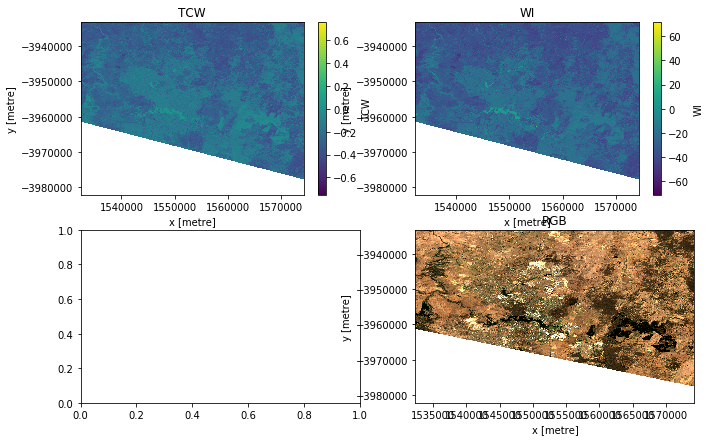

In [184]:
# Set up subplots
f, axarr = plt.subplots(2, 2, figsize=(11, 7), squeeze=False)

# Plot TCW
ds_tcw.isel(time=3).plot(cmap='viridis', ax=axarr[0, 0])
axarr[0, 0].set_title('TCW')

# Plot WI
ds_wi.isel(time=3).plot(cmap='viridis', ax=axarr[0, 1])
axarr[0, 1].set_title('WI')

# Plot RGB
rgb(ds_ard.isel(time=3),ax=axarr[1, 1],size=11)
axarr[1, 1].set_title('RGB')

### Create inundated vegetation mask

In [185]:
# Create inundated veg mask - both water (WI) and wet (TCW)
veg_mask = (np.logical_and(ds_wi>=-20,ds_tcw>=-0.2)) # where they are both greater than the minimum possible
in_veg = ds_wi.where(veg_mask==True,0)
in_veg = in_veg.where(veg_mask==False,1)

# Create inundated veg mask - only TCW
tcw_mask = ds_tcw>=-0.2

# What thresholds to use - Cate's:
# WI>=-10
# TCW>=-400

### Count amount of inundated vegetation pixels

Text(0.5, 1.0, 'TCW + WI')

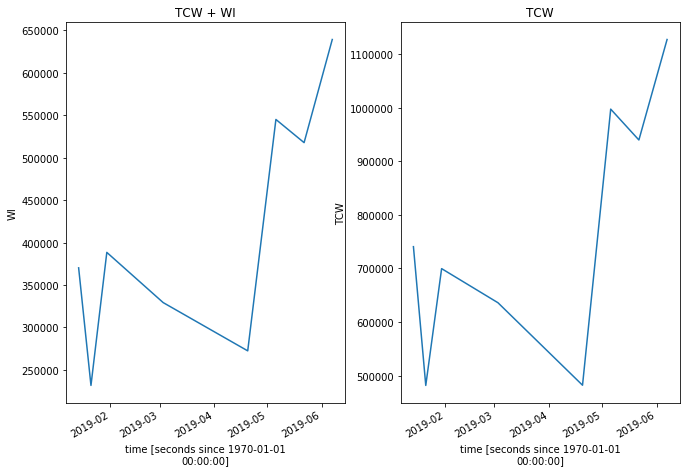

In [186]:
# Count inundated veg pixels
veg_count = in_veg.where(in_veg>0).count(dim=['x','y'])

# Count inundated veg pixels
tcw_count = tcw_mask.where(tcw_mask>0).count(dim=['x','y'])

# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(11, 7), squeeze=False)

tcw_count.plot(ax=axarr[0,1])
axarr[0,1].set_title('TCW')

veg_count.plot(ax=axarr[0,0])
axarr[0,0].set_title('TCW + WI')

### Calulate frequncy of inundated vegetation

Text(0.5, 1.0, 'RGB')

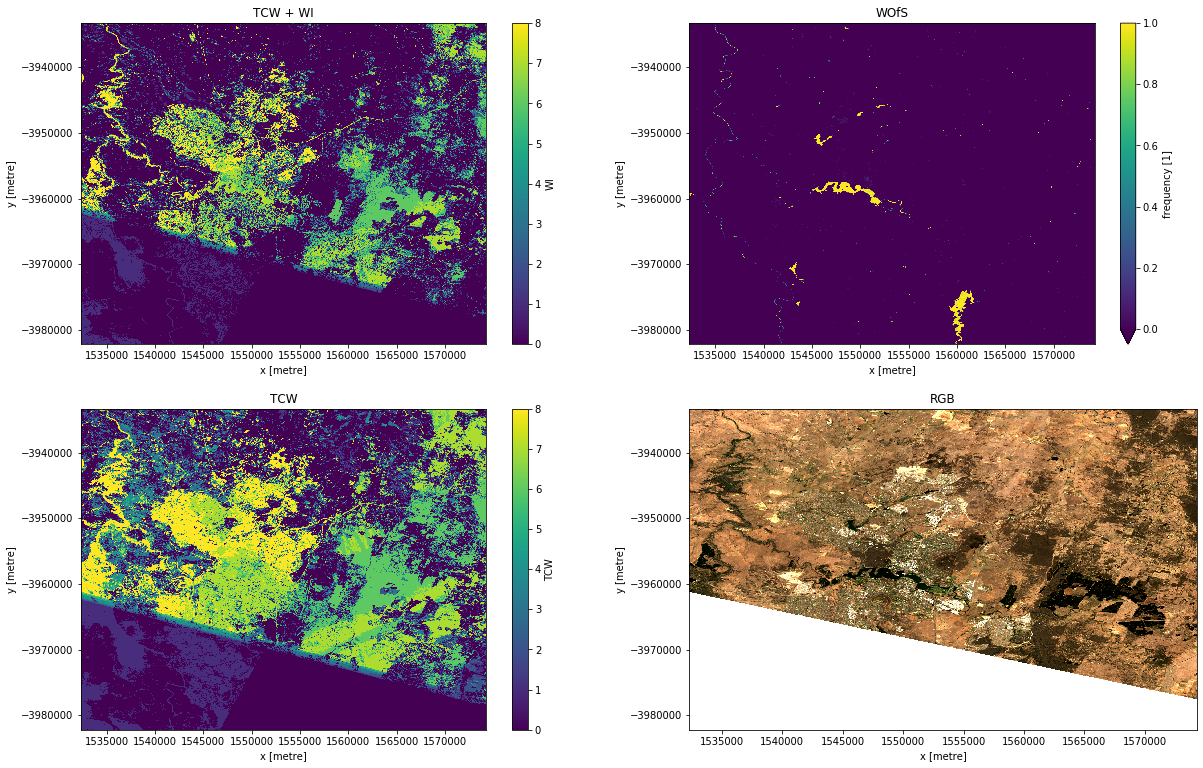

In [187]:
veg_freq = in_veg.sum(dim='time')

# frequency
tcw_freq = tcw_mask.sum(dim='time')

# Set up subplots
f, axarr = plt.subplots(2, 2, figsize=(20, 13), squeeze=False)

# Plot inundated veg - TCW + WI
veg_freq.plot(cmap='viridis', ax=axarr[0, 0])
axarr[0, 0].set_title('TCW + WI')

# Plot WOfS
ds_wofs.frequency.isel(time=0).plot(cmap='viridis', ax=axarr[0, 1], vmin=0)
axarr[0, 1].set_title('WOfS')

# Plot inundated veg
tcw_freq.plot(cmap='viridis', ax=axarr[1, 0])
axarr[1, 0].set_title('TCW')

# Plot RGB
rgb(ds_ard.isel(time=3),ax=axarr[1, 1],size=4)
axarr[1, 1].set_title('RGB')